In [133]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

import numpyro
import numpy as np 

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive





In [134]:
garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

# 7 Inputs
ages = []
massini = []
fehini = []
alphamlt = []
yini = []
eta = []
alphafe = []

# 8 Outputs
teff = []
luminosity = []
dnufit = []
FeH = []
G_GAIA = []
massfin = []
numax = []
MeH = []

# Open the hdf5 file (read-only mode)
with h5py.File(garstec_data, 'r') as hdf:

    grid = hdf['grid']
    tracks = grid['tracks']

    # Get a list of track names and shuffle for random sampling
    track_names = list(tracks.keys())
    random.seed(1)
    random.shuffle(track_names)

    # Choose a subset of tracks to process
    num_tracks = 1000  # Set the number of tracks to process
    selected_tracks = track_names[:num_tracks]
    print(selected_tracks[0])

    for track_name in selected_tracks:  # Iterate over the selected track names
        track = tracks[track_name]
        
        # Inputs
        ages.append(track['age'][:])
        massini.append(track['massini'][:])
        fehini.append(track['FeHini'][:])
        alphamlt.append(track['alphaMLT'][:])
        yini.append(track['yini'][:])
        eta.append(track['eta'][:])
        alphafe.append(track['alphaFe'][:])

        # Outputs
        teff.append(track['Teff'][:])
        luminosity.append(track['LPhot'][:])
        dnufit.append(track['dnufit'][:])
        FeH.append(track['FeH'][:])
        G_GAIA.append(track['G_GAIA'][:])
        massfin.append(track['massfin'][:])
        numax.append(track['numax'][:])
        MeH.append(track['MeH'][:])

# Convert lists to numpy arrays and concatenate them (make one big list)

# Define a small constant to avoid log10(0)
epsilon = 1e-10

# Features requiring log10 transformation
log10_vars_inputs = [ages, massini, alphamlt, eta, alphafe]

# Transform log10 variables
log10_transformed_inputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_inputs]

# Concatenate all inputs, including raw `fehini` and `yini`
inputs = np.hstack(log10_transformed_inputs + [np.concatenate(fehini).reshape(-1, 1), np.concatenate(yini).reshape(-1, 1)])

# Features requiring log10 transformation (strictly positive outputs)
log10_vars_outputs = [teff, luminosity, dnufit, G_GAIA, massfin, numax]

# Transform log10 variables
log10_transformed_outputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_outputs]

# Combine transformed log10 outputs with raw FeH and MeH
# FeH and MeH are not transformed, concatenated directly
outputs = np.hstack(log10_transformed_outputs + [np.concatenate(FeH).reshape(-1, 1), np.concatenate(MeH).reshape(-1, 1)])



track07294


In [135]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  


In [136]:
# Define the neural network
class GarstecNet(nn.Module):
    def __init__(self):
        super(GarstecNet, self).__init__()
        self.dense1 = nn.Linear(7, 64)   # Input layer
        self.dense2 = nn.Linear(64, 64)
        self.dense3 = nn.Linear(64, 64)  
        self.dense4 = nn.Linear(64, 64)
        self.dense5 = nn.Linear(64, 64)
        self.dense6 = nn.Linear(64, 8)    # Output layer
        

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = torch.relu(self.dense3(x))  
        x = torch.relu(self.dense4(x))
        x = torch.relu(self.dense5(x))
        x = self.dense6(x)
        return x

    
# Load the pre-trained model weights
model = GarstecNet()
model.load_state_dict(torch.load('garstec_model_V3_state.pth'))

# Set the model to evaluation mode
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


C:\Users\Dell\AppData\Local\Temp\ipykernel_2364\3765155684.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('garstec_model_V3_state.pth'

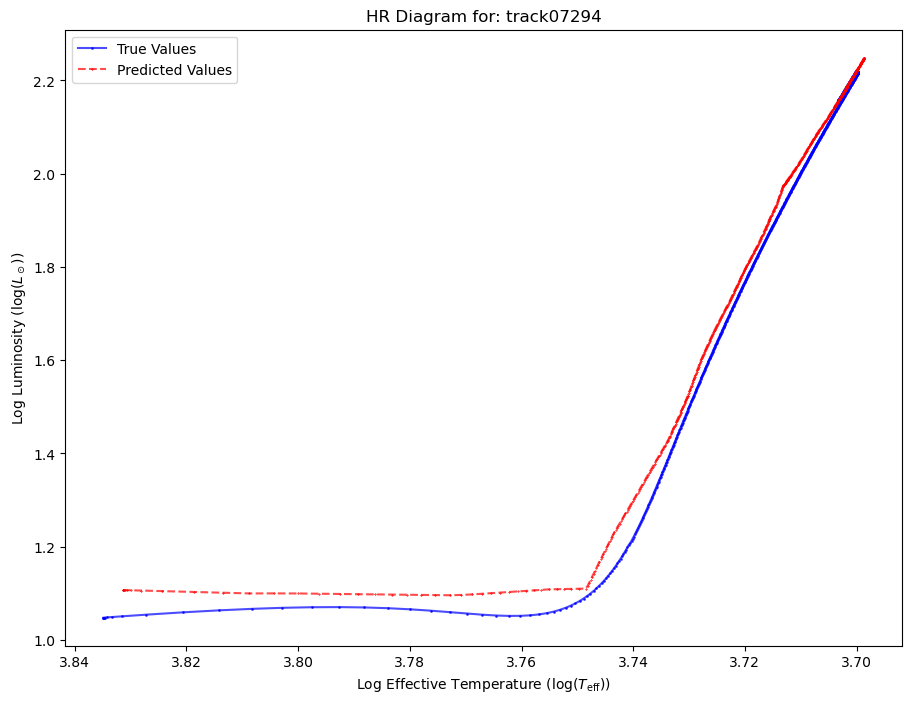

In [137]:
import jax.numpy as jnp
import h5py
import torch
import matplotlib.pyplot as plt

# Plotting for neural network and garstec track: 07294
specific_track_name = 'track07294'

# Retrieve all required inputs for track 07294
with h5py.File(garstec_data, 'r') as hdf:
    specific_track = hdf['grid']['tracks'][specific_track_name]

    ages = specific_track['age'][:].reshape(-1, 1)
    massini = specific_track['massini'][:].reshape(-1, 1)
    fehini = specific_track['FeHini'][:].reshape(-1, 1)
    alphamlt = specific_track['alphaMLT'][:].reshape(-1, 1)
    yini = specific_track['yini'][:].reshape(-1, 1)
    eta = specific_track['eta'][:].reshape(-1, 1)
    alphafe = specific_track['alphaFe'][:].reshape(-1, 1)

    # Combine features into a single array
    all_features = jnp.hstack((ages, massini, fehini, alphamlt, yini, eta, alphafe))

    # Outputs
    teff_specific = specific_track['Teff'][:]
    luminosity_specific = specific_track['LPhot'][:]
    dnufit_specific = specific_track['dnufit'][:]
    FeH_specific = specific_track['FeH'][:]
    G_GAIA_specific = specific_track['G_GAIA'][:]
    massfin_specific = specific_track['massfin'][:]
    numax_specific = specific_track['numax'][:]
    MeH_specific = specific_track['MeH'][:]

# Combine inputs and apply log10 transformations where required
epsilon = 1e-10
log10_vars_inputs = [ages, massini, alphamlt, eta, alphafe]
log10_transformed_inputs = [np.log10(np.maximum(var, epsilon)) for var in log10_vars_inputs]

# Combine log-transformed inputs with raw `fehini` and `yini`
all_features = np.hstack(log10_transformed_inputs + [fehini, yini])

# Convert `all_features` to numpy array before scaling
all_features_numpy = np.array(all_features)  # Convert to numpy for scaling
all_features_scaled = scaler_X.transform(all_features_numpy)  # Apply scaler

# Convert scaled inputs back to JAX array for consistency
all_features_scaled_jax = np.array(all_features_scaled)

# Convert scaled inputs to PyTorch tensor
all_features_tensor = torch.FloatTensor(all_features_scaled)

# Put the model in evaluation mode and make predictions
model.eval()
with torch.no_grad():
    predictions_specific = model(all_features_tensor).numpy()  # Make predictions
    predictions_specific = scaler_y.inverse_transform(predictions_specific)  # Inverse transform

# Extract predicted `Teff` and `Luminosity`
predicted_teff = 10**predictions_specific[:, 0]  # Inverse log10 transformation
predicted_luminosity = 10**predictions_specific[:, 1]

# Log-transform true values for plotting
log_actual_teff = np.log10(teff_specific)
log_actual_luminosity = np.log10(luminosity_specific)

# Log-transform predicted values for plotting
log_predicted_teff = np.log10(predicted_teff)
log_predicted_luminosity = np.log10(predicted_luminosity)

# Plot HR Diagram for the selected track
plt.figure(figsize=(10.8, 8))  # Slightly less than half-width of A4 landscape
plt.plot(log_actual_teff, log_actual_luminosity, label='True Values', color='blue', marker='o', markersize=1, linestyle='-', alpha=0.7)
plt.plot(log_predicted_teff, log_predicted_luminosity, label='Predicted Values', color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
plt.ylabel("Log Luminosity ($\log(L_\odot)$)")
plt.title(f"HR Diagram for: {specific_track_name}")
plt.legend()
plt.show()



In [138]:
import jax
import jax.numpy as jnp
"""
def emulate_with_pytorch(x, model, scaler_X, scaler_y):
    # Normalize inputs
    x_scaled = scaler_X.transform(x)  # Apply input scaling

    # Convert to PyTorch tensor
    x_tensor = torch.FloatTensor(x_scaled)

    # Pass through PyTorch model
    model.eval()
    with torch.no_grad():
        y_specific = model(x_tensor).numpy()
    y_specifc = scaler_y.inverse_transform(y_specific)

    y = y_specific
    print("Shape of y:", y.shape)
    return y  
    """

'\ndef emulate_with_pytorch(x, model, scaler_X, scaler_y):\n    # Normalize inputs\n    x_scaled = scaler_X.transform(x)  # Apply input scaling\n\n    # Convert to PyTorch tensor\n    x_tensor = torch.FloatTensor(x_scaled)\n\n    # Pass through PyTorch model\n    model.eval()\n    with torch.no_grad():\n        y_specific = model(x_tensor).numpy()\n    y_specifc = scaler_y.inverse_transform(y_specific)\n\n    y = y_specific\n    print("Shape of y:", y.shape)\n    return y  \n    '

In [139]:
state_dict = model.state_dict()
weight = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "weight" in name]
bias = [jnp.asarray(param.numpy()) for name, param in state_dict.items() if "bias" in name]

def emulate(x):
    if x.ndim == 1:
        x = x[None, :]  # Convert to shape (1, features) for a single sample

    # Hidden layers
    for i, (w, b) in enumerate(zip(weight[:-1], bias[:-1])):
        if x.shape[1] != w.shape[1]:
            raise ValueError(f"Shape mismatch in layer {i}: x.shape[1] ({x.shape[1]}) != w.shape[1] ({w.shape[1]})")
        #print(f"Layer {i}: x shape: {x.shape}, w.T shape: {w.T.shape}, b shape: {b.shape}")
        x = jax.nn.elu(jnp.dot(x, w.T) + b)

    # Final layer
    if x.shape[1] != weight[-1].shape[1]:  # Corrected check
        raise ValueError(f"Final layer mismatch: x.shape[1] ({x.shape[1]}) != weight[-1].shape[1] ({weight[-1].shape[1]})")
    #print(f"Final layer: x shape: {x.shape}, weight[-1].T shape: {weight[-1].T.shape}, bias[-1] shape: {bias[-1].shape}")
    x = jnp.dot(x, weight[-1].T) + bias[-1]
    return x





In [140]:
obs = {
    'teff': teff_specific,
    'lum': luminosity_specific,
    'dnu': dnufit_specific,
    'feh': FeH_specific,
    'gaia': G_GAIA_specific,
    'mass': massfin_specific,
    'numax': numax_specific,
    'meh': MeH_specific
}


In [141]:
def Bmodel(obs=None):
    # Define priors
    ages_ = numpyro.sample('ages_', dist.Normal(4300, 150))
    massini_ = numpyro.deterministic('massini_', 1.107 + numpyro.sample("massini_s", dist.Normal(0, 0.01)))
    fehini_ = numpyro.deterministic('fehini_', -1.15539551 + numpyro.sample("fehini_s", dist.Normal(0, 0.01)))
    alphamlt_ = numpyro.deterministic('alphamlt_', 2.02275391 + numpyro.sample("alphamlt_s", dist.Normal(0, 0.01)))
    yini_ = numpyro.deterministic('yini_', 0.24572388 + numpyro.sample("yini_s", dist.Normal(0, 0.01)))
    eta_ = numpyro.deterministic('eta_', 0.03665771 + numpyro.sample("eta_s", dist.Normal(0, 0.001)))
    alphafe_ = numpyro.deterministic('alphafe_', -0.2 + numpyro.sample("alphafe_s", dist.Normal(0, 0.01)))

    # Prepare input features for PyTorch model
    epsilon = 1e-10
    log_vars_inputs = [ages_, massini_, alphamlt_, eta_, alphafe_]
    log_transformed_inputs = [jnp.log10(jnp.maximum(var, epsilon)) for var in log_vars_inputs]
    x = jnp.stack(log_transformed_inputs + [fehini_, yini_]).reshape(-1, 7)

    # Emulate using PyTorch model
    y = emulate(x) # , model, scaler_X, scaler_y

    # Extract predictions
    teff, lum, dnu, feh, gaia, mass, numax, meh = (
        10**y[:, 0], 10**y[:, 1], 10**y[:, 2], y[:, 3], y[:, 4], 10**y[:, 5], 10**y[:, 6], y[:, 7]
    )

    # Observational likelihoods
    if obs is not None:
        numpyro.sample("teff_obs", dist.StudentT(5, teff, 50.0), obs=5206)
        numpyro.sample("lum_obs", dist.StudentT(3, lum, 0.05), obs=96)
        numpyro.sample("dnu_obs", dist.StudentT(5, dnu, 0.8), obs=5.44)
        numpyro.sample("feh_obs", dist.StudentT(4, feh, 0.02), obs=-1.1)
        numpyro.sample("gaia_obs", dist.StudentT(3, gaia, 0.01), obs=0.07)
        numpyro.sample("mass_obs", dist.StudentT(6, mass, 0.6), obs=1.1)
        numpyro.sample("numax_obs", dist.StudentT(4, numax, 0.02), obs=0.0175)
        numpyro.sample("meh_obs", dist.StudentT(4, meh, 0.02), obs=-1.26)


In [147]:
from jax import random

nuts = NUTS(Bmodel, target_accept_prob=0.8,  
            find_heuristic_step_size=True)
mcmc = MCMC(nuts, num_warmup=20000, num_samples=50000, num_chains=1)
rng = random.PRNGKey(0)
rng, key = random.split(rng)

mcmc.run(key, obs=1)

sample: 100%|██████████| 70000/70000 [25:50<00:00, 45.15it/s, 1023 steps of size 8.99e-04. acc. prob=0.95]  


In [148]:
import arviz as az

trace = az.from_numpyro(mcmc)
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ages_,0.222,0.003,0.216,0.227,0.0,0.0,1187.0,1822.0,NaN
alphafe_,0.002,0.000,0.001,0.003,0.0,0.0,3578.0,2393.0,NaN
alphafe_s,0.202,0.000,0.201,0.203,0.0,0.0,3578.0,2393.0,NaN
alphamlt_,2.023,0.010,2.004,2.042,0.0,0.0,2744.0,5891.0,NaN
alphamlt_s,0.001,0.010,-0.018,0.019,0.0,0.0,2744.0,5891.0,NaN
eta_,0.037,0.001,0.035,0.038,0.0,0.0,4124.0,8623.0,NaN
eta_s,-0.000,0.001,-0.002,0.002,0.0,0.0,4124.0,8623.0,NaN
fehini_,-1.160,0.010,-1.178,-1.142,0.0,0.0,2819.0,5372.0,NaN
fehini_s,-0.004,0.010,-0.022,0.014,0.0,0.0,2819.0,5372.0,NaN
massini_,1.111,0.010,1.092,1.130,0.0,0.0,1648.0,4383.0,NaN


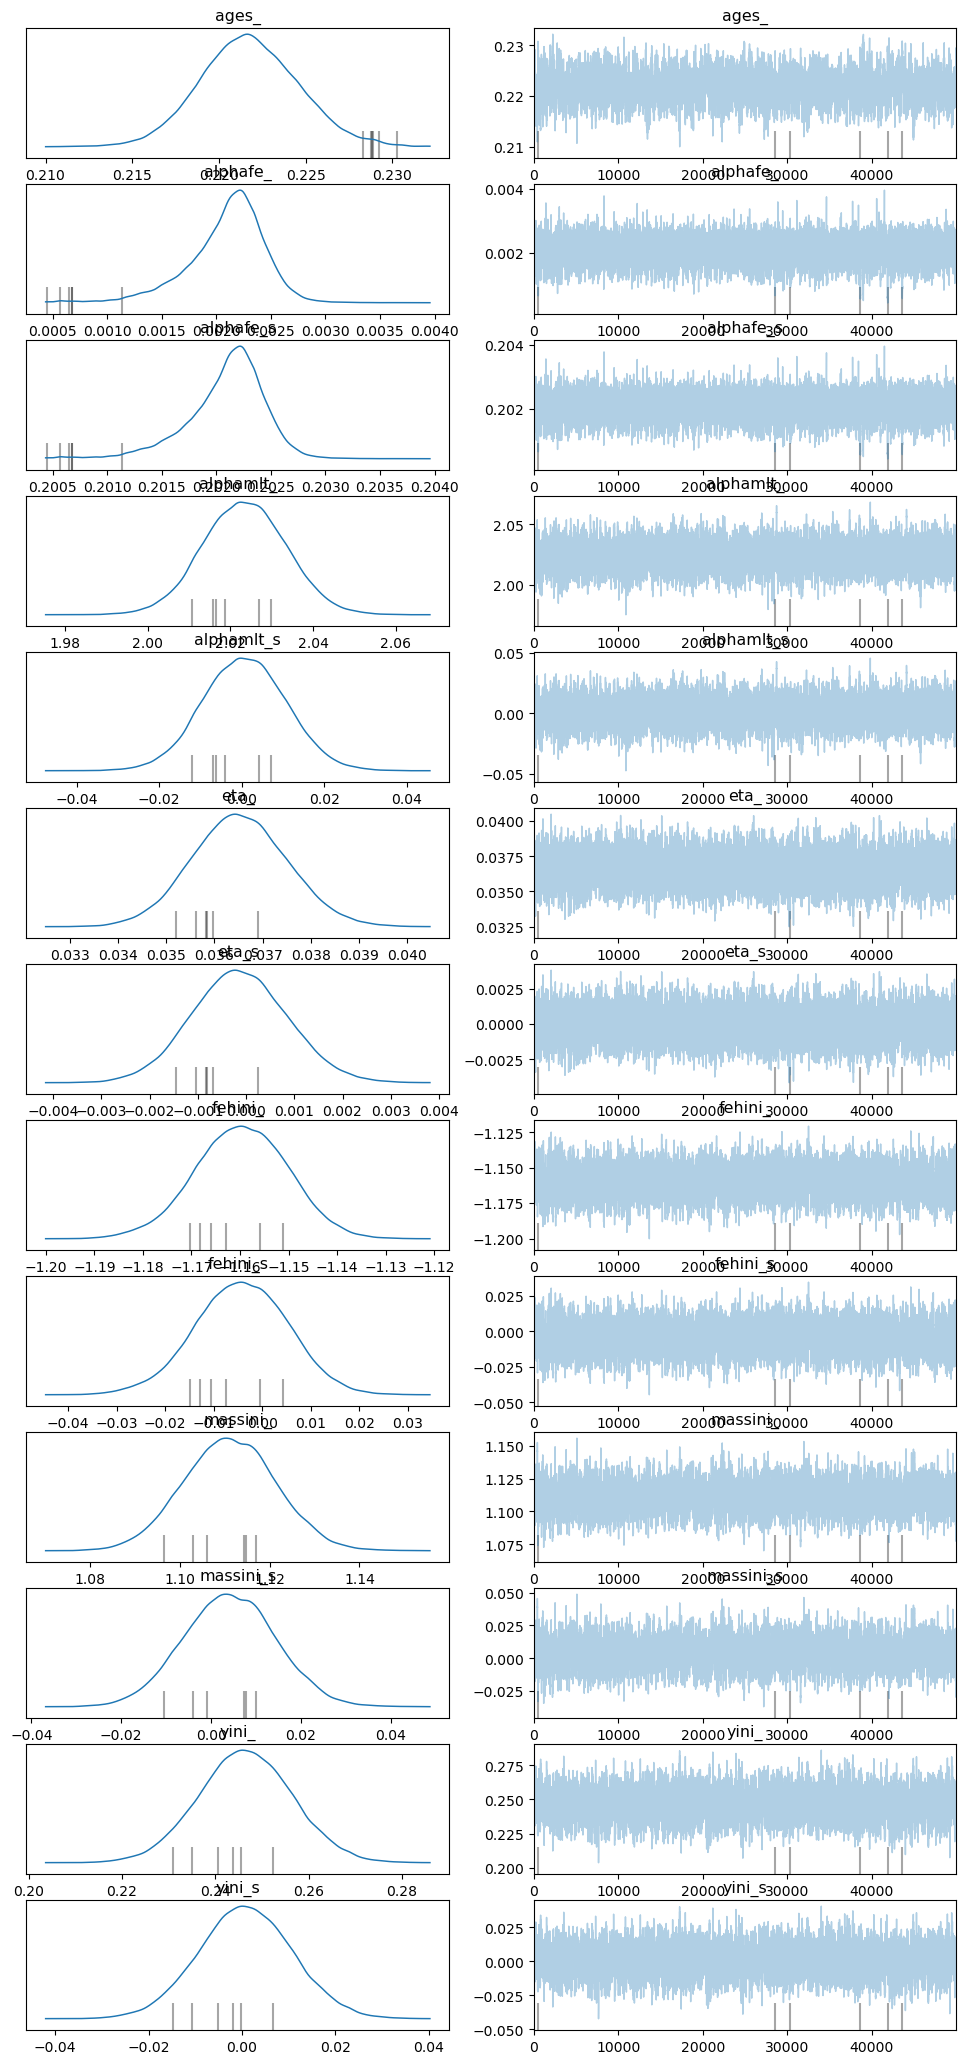

In [149]:
az.plot_trace(trace);

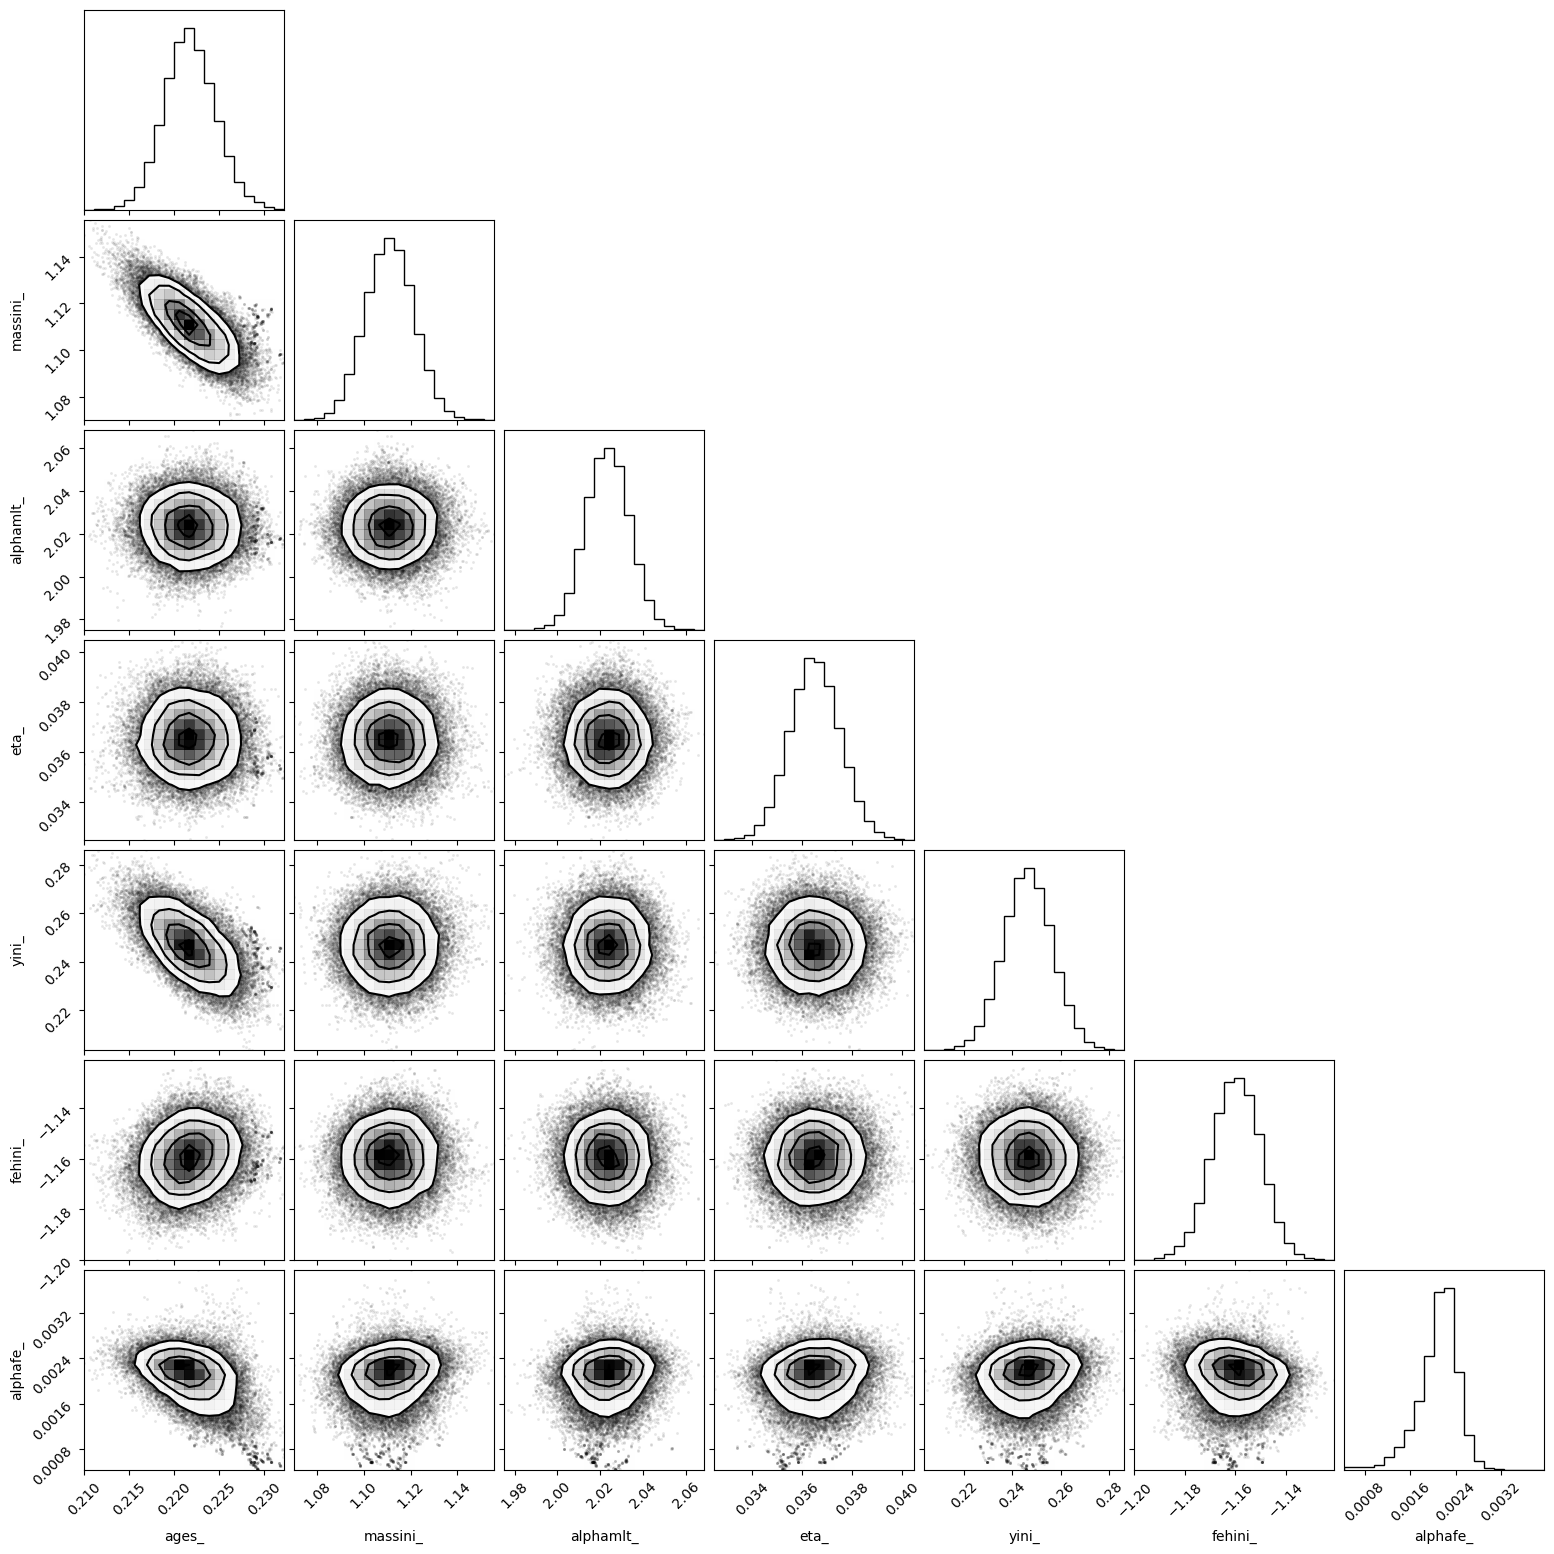

In [150]:
import corner

corner.corner(trace, var_names=['ages_', 'massini_', 'alphamlt_', 'eta_', 'yini_', 'fehini_', 'alphafe_'], 
             );